<a href="https://colab.research.google.com/github/tedteske/bounded_lognorm/blob/master/bounded_lognorm2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

The **bounded lognormal 2** is a continuous probability distribution derived from the [lognormal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution). Unlike the normal and lognormal distributions, the  support of the bounded lognormal may have both upper and lower bounds, and it may be symmetrical or skewed, depending on the parameters. It therefore may be a good fit for many natural phenomena, for which the domain of possible values is cosntrained, for example adult height and running speed.

The lognormal probability density function (pdf) is often defined in terms of $\mu_N$ and $\sigma_N$, the mean and standard deviation of some normal distribution $N$:


$$
f_L(x, \mu_N, \sigma_N ) = \frac{1}{x \sigma_N \sqrt{2 \pi}} \times exp(\frac{-(\ln(x) - \mu_N)^2}{2\sigma_N^2}) \tag{1}
$$

If we redefine $f_L$ in terms of mode $m$ and standard deviation $\sigma$ as $f_{L'}$, then the bounded lognormal pdf $f_{BL}$ is the piecewise function:

$$
f_{BL}(x, m, \sigma, upper) =
  \begin{cases}
    f_{L'}(x, m, \sigma)   &  \text{for } x <= m \\
    f_{L'}(upper-x, upper-m, \sigma)   &  \text{for } x > m \\
  \end{cases} \tag{2}
$$

where the second piece is scaled so that $f_{BL}$ is continuous at the mode, and $(lower, upper)$ are the lower and upper bounds of the support.

In contrast, the bounded lognormal 2 pdf $f_{BL2}$ is the non-piecewise function:

$$
f_{BL2}(x, m, \sigma, upper) =
    \sqrt{f_{L'}(x, m, \sigma)  
    \times
    f_{L'}(upper-x, upper-m, \sigma)}   
\tag{3}
$$

where $(lower, upper)$ are the lower and upper bounds of the support.

### Python Implementation: Class Definition

The bounded lognormal distribution is implemented in Python as an instance of the [scipy.stats.rv_continuous](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html#scipy.stats.rv_continuous) class and inherits from it a collection of generic methods.

In [4]:
#
# Author: Ted Teske 2020-2024
#

from scipy.stats import rv_continuous
from scipy.special import erf, erfinv
from scipy.optimize import curve_fit, minimize
from scipy.integrate import quad, fixed_quad, quad_vec
import numpy as np

"""
The following optional imports and plotting settings are for the examples
below, but are not necessary for the class definition itself.
"""
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from scipy.stats import norm, truncnorm, lognorm, beta
from scipy.stats import skew, kurtosis, normaltest, probplot
from scipy.interpolate import interp1d, make_interp_spline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = [10, 10/1.6]
"""
End of optional section.
"""


def lognorm_pdf(x, mu_N=0, sigma_N=1):
    """
    Log-normal (aka lognormal) probability density function (pdf).

    Parameters
    ----------
    x : {float, list or ndarray of floats}
        x-value(s)
    mu_N : float
        mean of underlying normal distribution
    sigma_N : float
        standard deviation of underlying normal distribution

    Returns
    -------
    y : ndarray of float(s)

    References
    ----------
    [1] https://en.wikipedia.org/wiki/Log-normal_distribution
    """
    # Creates an index of positive elements in x.
    x = np.atleast_1d(x)
    i = np.nonzero(x > 0)

    # Applies lognormal pdf to positive elements. All others evaluate to 0.
    y = np.zeros(len(x))
    y[i] = 1 / (x[i] * sigma_N * np.sqrt(2 * np.pi)) \
        * np.exp(-(np.log(x[i]) - mu_N)**2 / (2 * sigma_N**2))
    return y


def lognorm_cdf(x, mu_N=0, sigma_N=1):
    """
    Log-normal cumulative density function (cdf).

    Parameters
    ----------
    x : {float, list or ndarray of floats}
        x-value(s)
    mu_N : float
        mean of underlying normal distribution
    sigma_N : float
        standard deviation of underlying normal distribution

    Returns
    -------
    y : ndarray of float(s)

    References
    ----------
    [1] https://en.wikipedia.org/wiki/Log-normal_distribution
    """
    # Creates an index of positive elements in x.
    x = np.atleast_1d(x)
    i = np.nonzero(x > 0)

    # Applies lognormal cdf to positive elements. All others evaluate to 0.
    y = np.zeros(len(x))
    y[i] = 0.5 + 0.5 * erf((np.log(x[i]) - mu_N) / (np.sqrt(2) * sigma_N))
    return y


def lognorm_ppf(q, mu_N=0, sigma_N=1):
    """
    Log-normal percent-point function (ppf), also known as the quantile
    function, is the inverse of the cdf.

    Parameters
    ----------
    q : {float, list or ndarray of floats}
        quantile(s)
    mu_N : float
        mean of underlying normal distribution
    sigma_N : float
        standard deviation of underlying normal distribution

    Returns
    -------
    y : ndarray of float(s)

    References
    ----------
    [1] https://en.wikipedia.org/wiki/Log-normal_distribution
    """
    y = np.exp(mu_N + np.sqrt(2 * sigma_N**2) * erfinv(2 * q - 1))
    return y


def norm_pdf(x, mu_N=0, sigma_N=1):
    """
    Normal probability density function (pdf).

    Parameters
    ----------
    x : {float, list or ndarray of floats}
        x-value(s)
    mu_N : float
        mean
    sigma_N : float
        standard deviation

    Returns
    -------
    y : ndarray of float(s)

    References
    ----------
    [1] https://en.wikipedia.org/wiki/Normal_distribution
    """
    y = 1 / (sigma_N * np.sqrt(2 * np.pi))
    y *= np.exp(-(x - mu_N)**2 / (2 * sigma_N**2))
    return y


def norm_cdf(x, mu_N=0, sigma_N=1):
    """
    Normal cumulative density function (cdf).

    Parameters
    ----------
    x : {float, list or ndarray of floats}
        x-value(s)
    mu_N : float
        mean
    sigma_N : float
        standard deviation

    Returns
    -------
    y : ndarray of float(s)

    References
    ----------
    [1] https://en.wikipedia.org/wiki/Normal_distribution
    """
    y = 0.5 * (1 + erf((x - mu_N) / (sigma_N * np.sqrt(2))))
    return y


def lognorm_params(mode, sigma):
    """
    Given user-defined mode and sigma of a lognormal distribution,
    calculates the mu and sigma of its underlying normal distribution.

    Parameters
    ----------
    mode : float
        mode of lognormal distribution
    sigma : float
        standard deviation of lognormal distribution

    Returns
    -------
    mu_N : float
    sigma_N : float

    References
    ----------
    [1] Exact form adapted from the result of the query:
        solve[g^4 - g^3 - sigma^2/m^2] for g
        at https://www.wolframalpha.com. Accessed 21 Oct. 2020.
    [2] Numerical approximation from Warren Weckesser's answer to question at
        https://stackoverflow.com/questions/41464753. Accessed 21 Oct. 2020.

    """
    # Converts parameters to floats in case exponents below too big for ints.
    # https://stackoverflow.com/questions/67097840
    def GetItem(inputobject):
        while type(inputobject) is np.ndarray:
            inputobject = inputobject[0]
        return inputobject

    mode, sigma = float(GetItem(mode)), float(GetItem(sigma))

    # Finds the roots of the polynomial g^4 - g^3 - sigma^2/mode^2,
    # where g = e^(variance of the associated Normal distribution),
    # and uses just the real, positive root.
    try:
        # This is the exact form [1].
        a = np.cbrt(np.sqrt(81 * mode**8 * sigma**4 +
                            768 * mode**6 * sigma**6) -
                    9 * mode**4 * sigma**2)
        b = np.cbrt(2 / 3) * sigma**2
        c = np.cbrt(2 / 3)**2 * 2
        d = np.sqrt((-16 * b / a) + (c * a / mode**2) + 1)

        g1 = d / 4
        g2 = (4 * b / a) - a / (np.cbrt(18) * mode**2)
        g3 = 1 / (2 * d)

        g = g1 + np.sqrt(g2 + g3 + 0.5) / 2 + 0.25  # the real, positive root

        # Whereas the above is the real, positive root (the one we'll use),
        # negative or complex roots are commented below:
        # g =  g1 - np.sqrt(g2 + g3 + 0.5) / 2 + 0.25
        # g = -g1 + np.sqrt(g2 - g3 + 0.5) / 2 + 0.25
        # g = -g1 - np.sqrt(g2 - g3 + 0.5) / 2 + 0.25

    except:
        # And this is a slightly slower, numerical approximation of g [2].
        # It is however much more concise.
        p = np.poly1d([1, -1, 0, 0, -(sigma / mode)**2])
        r = p.roots
        g = r[(r.imag == 0) & (r.real > 0)].real

    # Plugs g into the expressions for sigma_N and mu_N.
    sigma_N = np.sqrt(np.log(g))
    mu_N = np.log(mode * g)
    return mu_N, sigma_N


class bounded_lognorm2_gen(rv_continuous):
    """
    Subclass of scipy.stats.rv_continuous [1]. This is used to generate a
    domain-bounded lognormal continuous probability distribution, which is
    fully described by the four parameters: mode, sigma, lower and upper
    bounds.

    The probability density function (pdf) concatenates two lognormal pdfs
        1. left-of-mode: lognormal pdf with loc at lower bound, and
        2. right-of-mode: reversed lognormal pdf with loc at upper bound and
            scaled so that the concatenated pdf is continuous at the mode;
    and scales the concatenated curve so that its integral equals 1.

    Methods
    -------
    same as scipy.stats.rv_continuous [1]

    References
    ----------
    [1] https://docs.scipy.org/doc/scipy/reference/generated
        /scipy.stats.rv_continuous.html
    """

    def __init__(self, name='bounded_lognorm2',
                 shapes='mode, sigma, lower, upper', n=1001):
        """
        Initializes class.

        Parameters
        ----------
        name : string
            name of instance
        shapes : string
            shape parameters, separated by commas
        order : int
            order of quadrature integration, used in cdf function
        n : int
            number of samples, used in ppf and stats functions
        """
        super().__init__()
        self.name = name
        self.shapes = shapes
        self.n = n
        return None

    def _argcheck(self, *args):
        """
        Overrides default _argcheck to allow negative parameters. Returns
        condition array of 1s where arguments are correct and 0s where they
        are not.
        """
        cond = 1
        for arg in args:
            if arg is None:
                arg = 0
            cond = np.logical_and(cond, np.isfinite(arg))
        return cond

    def _argcheck_final(self, x, mode, sigma, lower, upper,
                        ignore_checks=False):
        """
        Provides further compatibility checks and conversions for parameters.
        """
        # If lower or upper parameter is set to None, converts to a scalar so
        # that the curve below or above mode, respectively, approximates the
        # corresponding side of a normal(mode, sigma^2) distribution.
        normal_approx_factor=1e+3
        if lower is None:
            lower = mode - normal_approx_factor * sigma
        if upper is None:
            upper = mode + normal_approx_factor * sigma

        # Converts parameters to scalars, if necessary.
        try:
            mode, sigma, lower, upper = mode[0], sigma[0], lower[0], upper[0]
        except:
            pass

        # Checks parameters for compatibility with distribution.
        if not ignore_checks:
            param_conditions = (lower < mode < upper) & (sigma > 0)
            if not param_conditions:
                error_text = "Requires (lower < mode < upper) and (sigma > 0)"
                raise ValueError(error_text)

        # Converts scalar, list, or Series input to array.
        x = np.atleast_1d(x)
        mode = np.atleast_1d(mode)
        return x, mode, sigma, lower, upper

    def pdf(self, x, mode, sigma, lower=None, upper=None,
             ignore_checks=False, normed=True):
        """
        Probability density function (pdf).

        Parameters
        ----------
        x : {float, list, ndarray of floats}
            x-value(s)
        mode : float
            x at the point of maximum frequency [1]
        sigma : float
            indicates spread of data around mode. This approaches the standard
            deviation as lower and upper are increasingly distant from x.
        lower : float or None
            lower bound of the domain (x-values)
        upper : float or None
            upper bound of the domain (x-values)

        Returns
        -------
        relative likelihood [2] of x : ndarray of float(s)

        Note
        ----
        This is a wrapper for _pdf().

        References
        ----------
        [1] https://en.wikipedia.org/wiki/Mode_(statistics)
        [2] https://en.wikipedia.org/wiki/Probability_density_function
        """
        # Checks parameters for compatibility with distribution and converts.
        args = self._argcheck_final(x, mode, sigma, lower, upper,
                                    ignore_checks=ignore_checks)
        x, mode, sigma, lower, upper = args

        # Shifts x, lower, upper, and mode so that lower is at 0;
        # allows negative x-values.
        x, mode, upper = x - lower, mode - lower, upper - lower

        y_left = lognorm_pdf(x, *lognorm_params(mode, sigma))
        y_right = lognorm_pdf(upper - x, *lognorm_params(upper - mode, sigma))
        y = y_left * y_right
        y = np.sqrt(y)

        # Normalizes concatenated pdf to area == 1.
        if normed:
            scale = self.cdf(upper, mode, sigma, 0, upper, normed=False)
            y = y / scale
        return y

    def logpdf(self, x, mode, sigma, lower=None, upper=None):
        """
        Log of the probability density function (pdf). See bounded_lognorm.pdf
        for a description of parameters.
        """
        with np.errstate(divide='ignore'):
            return np.log(self.pdf(x, mode, sigma, lower, upper))

    def cdf(self, x, mode, sigma, lower, upper,
            ignore_checks=False, normed=True):
        """
        Cumulative density function (cdf).

        Parameters
        ----------
        x : {float, list, ndarray of floats}
            x-value(s)
        mode : float
            x at the point of maximum frequency [1]
        sigma : float
            indicates spread of data around mode. This approaches the standard
            deviation as lower and upper are increasingly distant from x.
        lower : float or None
            lower bound of the domain (x-values)
        upper : float or None
            upper bound of the domain (x-values)

        Returns
        -------
        probability(s) that random variable <= x : ndarray of float(s)

        Note
        ----
        This is a wrapper for _cdf().

        References
        ----------
        [1] https://en.wikipedia.org/wiki/Mode_(statistics)
        [2] https://en.wikipedia.org/wiki/Cumulative_distribution_function
        [3] https://people.sc.fsu.edu/~jpeterson/numerical_quadrature
        """
        # Checks parameters for compatibility with distribution and converts.
        args = self._argcheck_final(x, mode, sigma, lower, upper,
                                    ignore_checks=ignore_checks)
        x, mode, sigma, lower, upper = args
        y = []
        x = np.atleast_1d(x)
        order = 2 * self.n - 1  #max order of quadrature integration [3]
        args = mode, sigma, lower, upper, False, normed
        for x_ in x:
            y_ = fixed_quad(self.pdf, lower, x_, args=args, n=order)[0]
            y.append(y_)
        return y

    def logcdf(self, x, mode, sigma, lower=None, upper=None):
        """
        Log of the cumulative density function (cdf). See bounded_lognorm.cdf
        for a description of parameters.
        """
        with np.errstate(divide='ignore'):
            return np.log(self.cdf(x, mode, sigma, lower, upper))

    def sf(self, x, mode, sigma, lower=None, upper=None):
        """
        Survival function, 1 - cdf. See bounded_lognorm.cdf
        for a description of parameters.
        """
        return 1.0 - self.cdf(x, mode, sigma, lower, upper)

    def logsf(self, x, mode, sigma, lower=None, upper=None):
        """
        Log of the survival function. See bounded_lognorm.cdf
        for a description of parameters.
        """
        with np.errstate(divide='ignore'):
            return np.log(self.sf(x, mode, sigma, lower, upper))

    def ppf(self, q, mode, sigma, lower, upper, ignore_checks=False):
        """
        Percent-point function (ppf), also known as the quantile function, is
        the inverse of the cdf.

        Parameters
        ----------
        q : {float, list, ndarray of floats}
            quantile(s), lower tail probability
        mode : float
            x at the point of maximum frequency [1]
        sigma : float
            indicates spread of data around mode. This approaches the standard
            deviation as lower and upper are increasingly distant from x.
        lower : float or None
            lower bound of the domain (x-values)
        upper : float or None
            upper bound of the domain (x-values)

        Returns
        -------
        x-value(s), such that P(X <= x) is q : ndarray of float(s) [2]

        References
        ----------
        [1] https://en.wikipedia.org/wiki/Mode_(statistics)
        [2] https://en.wikipedia.org/wiki/Quantile_function
        """
        # Checks parameters for compatibility with distribution and converts.
        args = self._argcheck_final(q, mode, sigma, lower, upper,
                                    ignore_checks=ignore_checks)
        q, mode, sigma, lower, upper = args

        ys = np.linspace(lower, upper, self.n).squeeze()
        xs = self.cdf(ys, mode, sigma, lower, upper)
        xs = np.asarray(xs).flatten()
        f = interp1d(xs, ys, fill_value='extrapolate')
        return f(q)

    def isf(self, q, mode, sigma, lower=None, upper=None):
        """
        Inverse survival function. See bounded_lognorm.ppf
        for a description of parameters.
        """
        return self.ppf(1.0 - q, mode, sigma, lower, upper)

    def rvs(self, mode, sigma, lower=None, upper=None, size=1,
            random_state=None):
        """
        Generates random variate(s) using inverse transform sampling [1].

        Parameters
        ----------
        mode : float
            x at the point of maximum frequency [2]
        sigma : float
            indicates spread of data around mode. This approaches the standard
            deviation as lower and upper are increasingly distant from x.
        lower : float or None
            lower bound of the domain (x-values)
        upper : float or None
            upper bound of the domain (x-values)
        size : int
            number of random variates to generate
        random_state : None, int, or numpy.random.RandomState
            not used; for backward compatibility only

        Returns
        -------
        ndarray of float(s)

        References
        ----------
        [1] https://en.wikipedia.org/wiki/Inverse_transform_sampling
        [2] https://en.wikipedia.org/wiki/Mode_(statistics)
        """
        '''
        # Alternate rvs using rejection_sampler
        # https://stackoverflow.com/questions/41470070/python-random-sampling-from-self-defined-probability-function
        # https://towardsdatascience.com/random-sampling-with-scipy-and-numpy-part-iii-8daa212ce554
        pmax = self._pdf(mode, mode, sigma, lower, upper)
        results = []
        while len(results) < size:
            a = np.random.rand(1) * (upper - lower) + lower
            b = np.random.rand(1) * pmax
            if b <= self._pdf(a, mode, sigma, lower, upper):
                results.append(a[0])
        return np.atleast_1d(results)
        '''
        uniform_rands = np.random.uniform(size=int(size))
        return self.ppf(uniform_rands, mode, sigma, lower, upper)

    def _stats(self, mode, sigma, lower, upper, moments='mv'):
        """
        Calculates population mean('m'), variance('v'), skew('s'),
        and/or kurtosis('k'). Do not call this directly;
        call stats(), a wrapper for this function, instead.

        References
        ----------
        [1] Raiford, Theodore E. “Skewness of Combined Distributions.”
            Journal of the American Statistical Association,
            vol. 37, no. 219, 1942, pp. 391–393.
            JSTOR, https://www.jstor.org/stable/2279009.
            Accessed 18 Sept. 2020.
        [2] Wang, Yibing, et. al. "Speed Modeling and Travel Time Estimation
            Based on Truncated Normal and Lognormal Distributions."
            Transportation Research Record, No. 2315, 2012, pp. 66-72.
            ResearchGate, http://www.researchgate.net/publication/272774439.
            Accessed 18 Sept. 2020.
        [3] Ford and McLaren. "METHODS FOR OBTAINING DISTRIBUTIONS OF
            URANIUM OCCURRENCE FROM ESTIMATES OF GEOLOCJ:C FEATURES." Union
            Carbide Corporation for the Department of Energy, 1980.
            U.S. Department of Energy Office of Scientific and Technical
            Information, https://www.osti.gov/servlets/purl/5121047.
            Accessed 18 Sept. 2020.
        [4] https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm
        [5] https://berkeley-stat159-f17.github.io/stat159-f17/lectures/09-intro-numpy/trapezoid..html
        [6] http://www.appliedbusinesseconomics.com/files%5Cgvsplndrn01.pdf
        """

        # Checks parameters for compatibility with distribution and converts.
        args = self._argcheck_final(0, mode, sigma, lower, upper)
        _, mode, sigma, lower, upper = args

        n = self.n
        xs = np.linspace(lower, upper, num=n).squeeze()
        ys = self.pdf(xs, mode, sigma, lower, upper)
        ps = ys * (upper - lower) / n #probabilities

        # mean, numerically
        mu = np.sum(xs * ps)

        # variance and standard deviation, numerically
        mu2 = np.sum((xs - mu)**2 * ps)
        s = np.sqrt(mu2)

        # skewness, numerically
        g1 = np.sum(((xs - mu) / s)**3 * ps)
        g1 *= np.sqrt(n * (n - 1)) / (n - 2) # adjustment for sample size [4]

        # kurtosis, numerically
        g2 = np.sum(((xs - mu) / s)**4 * ps) - 3
        return mu, mu2, g1, g2

    def stats(self, mode, sigma, lower=None, upper=None, moments='mv'):
        """
        Calculates population mean('m'), variance('v'), skew('s'),
        and/or kurtosis('k').

        Parameters
        ----------
        mode : float
            x at the point of maximum frequency
        sigma : float
            indicates spread of data around mode. This approaches the standard
            deviation as lower and upper are increasingly distant from x.
        lower : float or None
            lower bound of the domain (x-values)
        upper : float or None
            upper bound of the domain (x-values)
        moments : str, optional
            composed of letters ['mvsk'] defining which moments to compute:
            'm' = mean,
            'v' = variance,
            's' = (Fisher's) skew,
            'k' = (Fisher's) kurtosis.
            (default is 'mv')

        Returns
        -------
        ndarray
        """
        output = []
        mu, mu2, g1, g2 = self._stats(mode, sigma, lower, upper)
        if 'm' in moments:
            output.append(mu)
        if 'v' in moments:
            output.append(mu2)
        if 's' in moments:
            output.append(g1)
        if 'k' in moments:
            output.append(g2)
        if len(output) == 1:
            return output[0]
        else:
            return tuple(output)

    def moment(self, n, mode, sigma, lower=None, upper=None):
        """
        Calculates n-th order non-central moment of distribution.

        Parameters
        ----------
        n : int, 0 <= n <= 4
            order of moment
        mode : float
            x at the point of maximum frequency
        sigma : float
            indicates spread of data around mode. This approaches the standard
            deviation as lower and upper are increasingly distant from x.
        lower : float or None
            lower bound of the domain (x-values)
        upper : float or None
            upper bound of the domain (x-values)

        Returns
        -------
        float
        """
        mu, mu2, g1, g2 = self._stats(mode, sigma, lower, upper)
        mu3 = g1 * mu2**1.5
        mu4 = (g2 + 3.0) * mu2**2

        if n == 0:
            return 1.0
        elif n == 1:
            return mu
        elif n == 2:
            return mu2 + mu**2
        elif n == 3:
            return mu3 + mu * (mu**2 + 3 * mu2)
        elif n == 4:
            return mu4 + mu * ((mu**2 + 6 * mu2) * mu + 4 * mu3)
        else:
            pass

    def support(self, mode, sigma, lower=None, upper=None):
        """
        End-points of the distribution's support. See bounded_lognorm.pdf for
        a description of the parameters mode, sigma, lower, upper.
        """
        # Checks parameters for compatibility with distribution and converts.
        args = self._argcheck_final(0, mode, sigma, lower, upper)
        _, mode, sigma, lower, upper = args

        return lower, upper

    def median(self, mode, sigma, lower=None, upper=None):
        """
        Median. See bounded_lognorm.pdf for a description of the parameters
        mode, sigma, lower, upper.
        """
        return self.ppf(0.5, mode, sigma, lower, upper)

    def mean(self, mode, sigma, lower=None, upper=None):
        """
        Mean. See bounded_lognorm.pdf for a description of the parameters
        mode, sigma, lower, upper.
        """
        return self.stats(mode, sigma, lower, upper, moments='m')

    def var(self, mode, sigma, lower=None, upper=None):
        """
        Variance. See bounded_lognorm.pdf for a description of the parameters
        mode, sigma, lower, upper.
        """
        return self.stats(mode, sigma, lower, upper, moments='v')

    def std(self, mode, sigma, lower=None, upper=None):
        """
        Standard deviation. See bounded_lognorm.pdf for a description of the
        parameters mode, sigma, lower, upper.
        """
        return np.sqrt(self.var(mode, sigma, lower, upper))

    def entropy(self, mode, sigma, lower=None, upper=None):
        """
        Differential entropy of the random variable.

        Parameters
        ----------
        mode : float
            x at the point of maximum frequency [1]
        sigma : float
            indicates spread of data around mode. This approaches the standard
            deviation as lower and upper are increasingly distant from x.
        lower : float or None
            lower bound of the domain (x-values)
        upper : float or None
            upper bound of the domain (x-values)

        Returns
        -------
        entropy in natural units of information (nats) [2]

        References
        ----------
        [1] https://en.wikipedia.org/wiki/Mode_(statistics)
        [2] https://en.wikipedia.org/wiki/Differential_entropy
        [3] https://en.wikipedia.org/wiki/Truncated_normal_distribution
        """
        # Checks parameters for compatibility with distribution and converts.
        args = self._argcheck_final(0, mode, sigma, lower, upper)
        _, mode, sigma, lower, upper = args
        """
        The first draft uses the generic formula for differential
        entropy [2] and numeric integration:

            from scipy.integrate import quad
            from scipy.special import entr
            def pdf_times_logpdf(x):
                # Function to be integrated below.
                return entr(self.pdf(x, mode, sigma, lower, upper))
            return quad(pdf_times_logpdf, lower, upper)[0]

        but is found not to be robust to the following cases:
            mode, sigma, lower, upper = 1, .062, 0, 100
            mode, sigma, lower, upper = 950, 1, -1000, 1000

        The implemation below adapts the formula for entropy of the
        truncated normal distribution [3].
        """
        mu, var = self.stats(mode, sigma, lower, upper)
        std = np.sqrt(var)
        alpha = (lower - mu)/std
        beta = (upper - mu)/std
        Z = norm_cdf(beta) - norm_cdf(alpha)
        entropy = 0.5 * np.log(2 * np.pi * np.e * var * Z**2)
        entropy += (alpha * norm_pdf(alpha) - beta * norm_pdf(beta)) / (2 * Z)
        return entropy

    def nnlf(self, x, mode, sigma, lower=None, upper=None):
        """
        Negative loglikelihood function. See bounded_lognorm.pdf
        for a description of parameters.
        """
        return -np.sum(self.logpdf(x, mode, sigma, lower, upper), axis=0)

    def fit(self, data, MLE=True, verbose=False,
            fmode=None, fsigma=None, flower=None, fupper=None,
            gmode=None, gsigma=None, glower=None, gupper=None):
        """
        Estimates bounded_lognorm parameters from user-supplied random
        variates.

        Parameters
        ----------
        data : {list of floats, ndarray of floats}
            random variates
        MLE : boolean
            If True, use maximum likelihood estimation (default).
            If False, use least squares estimation.
        verbose : boolean
            If True, return verbose fit results.
        fmode, fsigma, flower, fupper : {None, float}
            parameters held to fixed constants
        gmode, gsigma, glower, gupper : {None, float}
            initial guesses, overridden by fixed parameters

        Returns
        -------
        shapes : ndarray
            shape parameters (mode, sigma, lower, upper)
        results : verbose output of fit algorithm used, if verbose=True
            If MLE==True, dictionary of optimization results
            If MLE==False, tuple containing
                popt : ndarray
                    estimated (i.e. non-fixed) parameters
                pcov : ndarray
                    estimated covariance matrix of popt

        Note
        ----
        "The diagonals [of pcov] provide the variance of the parameter
        estimate. To compute one standard deviation errors on the parameters
        use perr = np.sqrt(np.diag(pcov))." [1]

        References
        ----------
        [1] https://docs.scipy.org/doc/scipy/reference/generated
            /scipy.optimize.curve_fit.html
        """
        # Converts data to array and creates a container for shape parameters.
        data = np.asarray(data)
        sample_size = len(data)
        shapes = np.ones(4)

        # Collects fixed parameters in fparams.
        fparams = np.array([fmode, fsigma, flower, fupper])
        fmask = (fparams != np.array(None))
        shapes[fmask] = fparams[fmask]

        # Collects guessed parameters in gparams and applies default guesses
        # where none supplied by user.
        gparams = np.array([gmode, gsigma, glower, gupper])
        minmax_cushion = 0.0001  # Otherwise, fit tends to fail.
        gdefaults = np.array([np.median(data), data.std(),
                              data.min() * (1 - minmax_cushion),
                              data.max() * (1 + minmax_cushion)])
        gmask = (gparams != np.array(None))
        gparams[~gmask] = gdefaults[~gmask]
        gparams = np.array(gparams[~fmask], dtype='float64')

        # This is the objective function to be minimized by MLE below.
        # Returns the negative log-likelihood of the to-be-fitted pdf.
        def minimize_this(args):
            shapes[~fmask] = args
            return self.nnlf(data, *shapes)

        # This is the function to be fit by curve_fit below. Wraps the cdf
        # and pdf to hold fixed parameters constant.
        def curve_to_be_fit(x, *args):
            shapes[~fmask] = args
            if fit_cdf:
                return self.cdf(x, *shapes, ignore_checks=True)
            else:
                return self.pdf(x, *shapes, ignore_checks=True)

        # Why are these ignores necessary?
        with np.errstate(invalid='ignore', divide='ignore'):

            if MLE:  # maximum likelihood estimation
                results = minimize(minimize_this, gparams,
                                   method='Nelder-Mead')
                if not results.success:
                    raise Exception(results)
                else:
                    shapes[~fmask] = results.x

            else:  # non-linear least squares estimation

                try:  # Fits cdf.
                    # Converts data to ecdf.
                    xdata, counts = np.unique(data, return_counts=True)
                    ydata = np.cumsum(counts, dtype=np.double) / sample_size

                    # Fits estimated population cdf to ecdf.
                    fit_cdf = True
                    results = curve_fit(curve_to_be_fit, xdata, ydata,
                                        p0=gparams)

                except:  # If that doesn't work, tries fitting pdf instead.
                    # Converts data to histogram.
                    ydata, xdata = np.histogram(data, density=True,
                                                bins=sample_size)
                    # Sets xdata to center of bin edges.
                    xdata = np.mean([xdata[:-1], xdata[1:]], axis=0)

                    # Fits estimated population pdf to histogram.
                    fit_cdf = False
                    results = curve_fit(curve_to_be_fit, xdata, ydata,
                                        p0=gparams)

                shapes[~fmask] = results[0]

            if verbose:
                return shapes, results
            else:
                return shapes

bl2 = bounded_lognorm2_gen()

### Example Usage

#### Function Plots and Random Number Generation

Probability density functions (pdf) with various modes, sigmas, and boundaries.

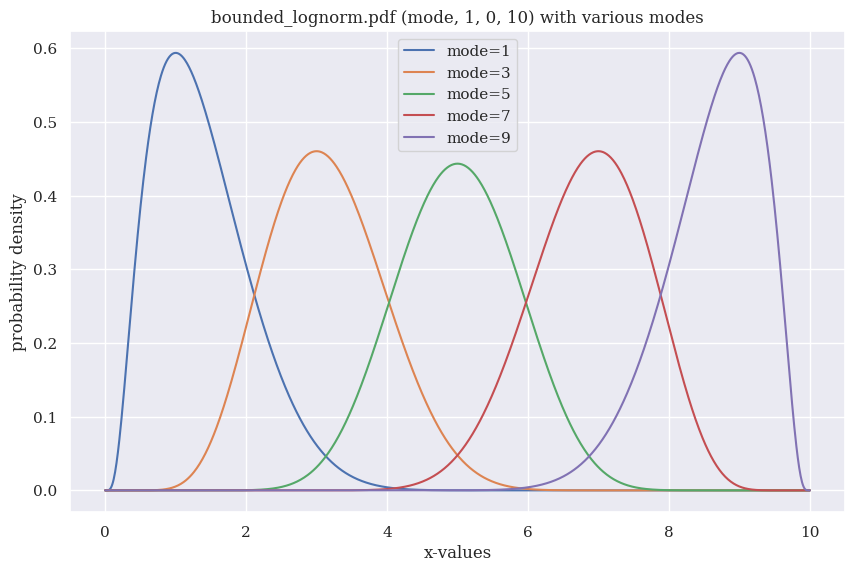

In [5]:
modes = [1, 3, 5, 7, 9]
sigma = 1
lower, upper = 0, 10
x = np.linspace(lower, upper, 1000)
for mode in modes:
    y = bl2.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x=x, y=y, label='mode=' + str(mode))
title = 'bounded_lognorm.pdf (mode, {}, {}, {}) with various modes'
title = title.format(sigma, lower, upper)
plt.xlabel("x-values")
plt.ylabel("probability density")
plt.title(title)
plt.show()

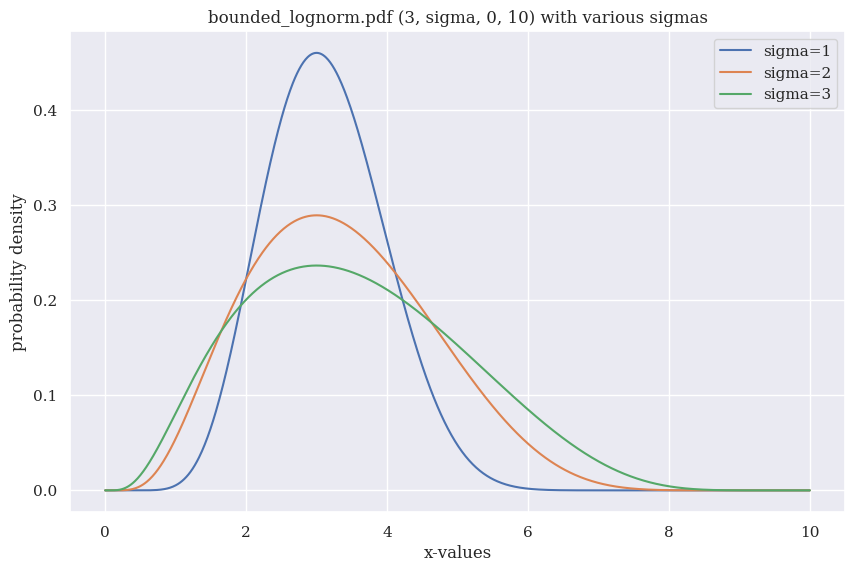

In [6]:
mode = 3
sigmas = [1, 2, 3]
lower, upper = 0, 10
x = np.linspace(lower, upper, 1000)
for sigma in sigmas:
    y = bl2.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x=x, y=y, label='sigma=' + str(sigma))
title = 'bounded_lognorm.pdf ({}, sigma, {}, {}) with various sigmas'
title = title.format(mode, lower, upper)
plt.xlabel("x-values")
plt.ylabel("probability density")
plt.title(title)
plt.show()

Probability density function (pdf) with 95% confidence interval

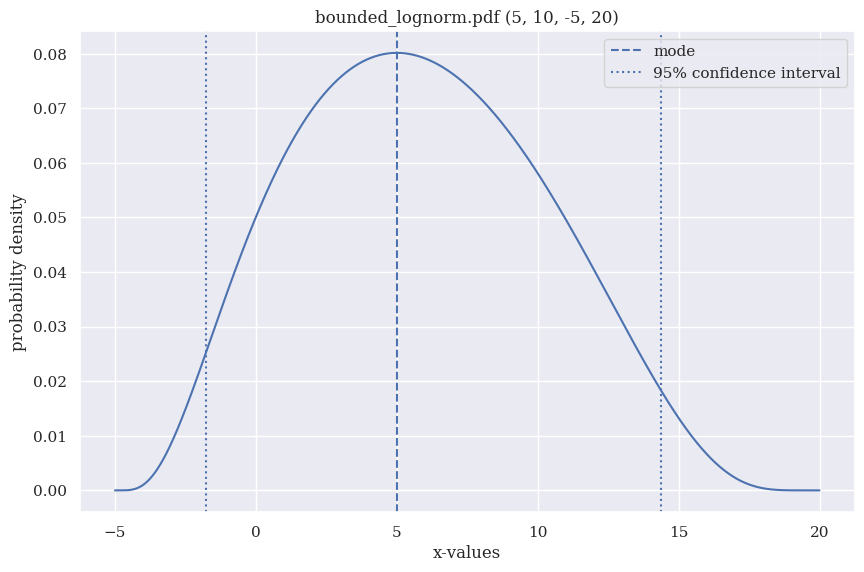

In [7]:
mode, sigma = 5, 10
lower, upper = -5, 20

x = np.linspace(lower, upper, 1000)
y = bl2.pdf(x, mode, sigma, lower, upper)
sns.lineplot(x=x, y=y)
plt.axvline(mode, ymin=0, linestyle='dashed', label='mode')

interval = bl2.interval(0.95, mode, sigma, lower, upper)
plt.axvline(interval[0], ymin=0, linestyle='dotted',
            label='95% confidence interval')
plt.axvline(interval[1], ymin=0, linestyle='dotted')
title = title = 'bounded_lognorm.pdf ({}, {}, {}, {})'
title = title.format(mode, sigma, lower, upper)
plt.xlabel("x-values")
plt.ylabel("probability density")
plt.title(title)
plt.legend()
plt.show()

In [8]:
%timeit -r 3 -n 10 bl2.pdf(x, mode, sigma, lower, upper)

1.54 ms ± 591 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


Cumulative distribution function (cdf)

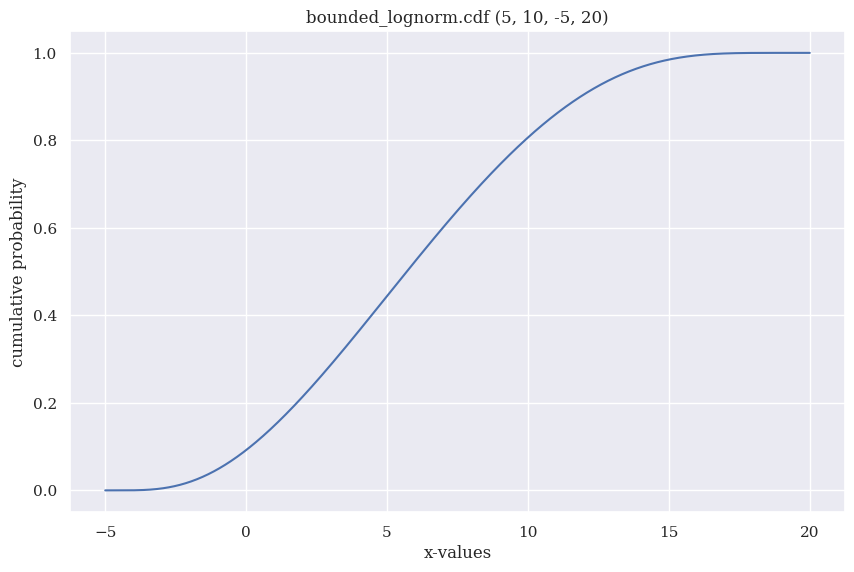

In [9]:
x = np.linspace(lower, upper, 1000)
y = bl2.cdf(x, mode, sigma, lower, upper)
sns.lineplot(x=x, y=y)
title = title = 'bounded_lognorm.cdf ({}, {}, {}, {})'
title = title.format(mode, sigma, lower, upper)
plt.xlabel("x-values")
plt.ylabel("cumulative probability")
plt.title(title)
plt.show()

Percent point function (ppf), also known as the quantile function, is the inverse of the cdf.

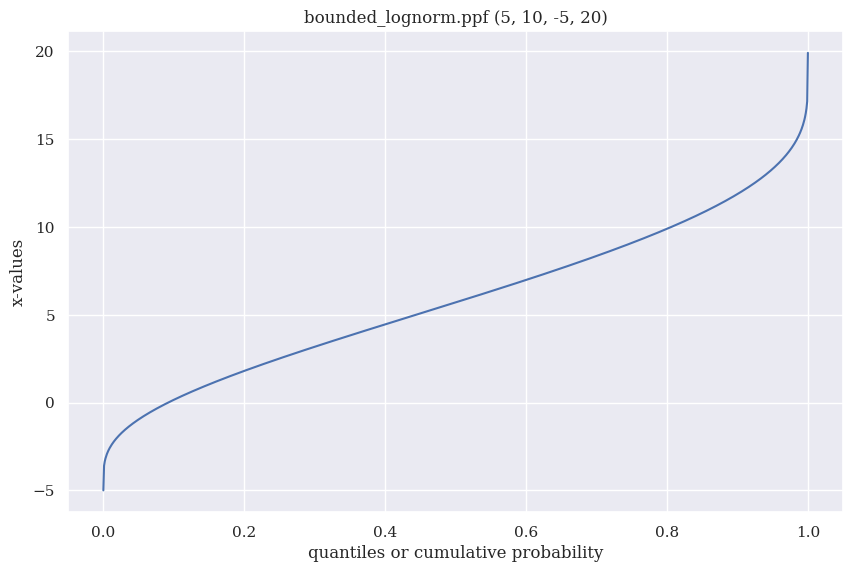

In [10]:
x = np.linspace(0, 1, 1000)
y = bl2.ppf(x, mode, sigma, lower, upper)
sns.lineplot(x=x, y=y)
title = title = 'bounded_lognorm.ppf ({}, {}, {}, {})'
title = title.format(mode, sigma, lower, upper)
plt.xlabel("quantiles or cumulative probability")
plt.ylabel("x-values")
plt.title(title)
plt.show()

In [11]:
%timeit -r 3 -n 10 bl2.ppf(x, mode, sigma, lower, upper)

628 ms ± 58.9 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


Print 10 random numbers from this distribution.

In [12]:
bl2.rvs(mode, sigma, lower, upper, size=10)

array([ 7.479531  , -0.4336152 ,  3.16943094, -1.20677285, 10.77299792,
        6.96439762,  2.95837503, 10.03383288,  3.57825575,  3.52339792])

Plot a histogram of 10,000 random numbers from this distribution.

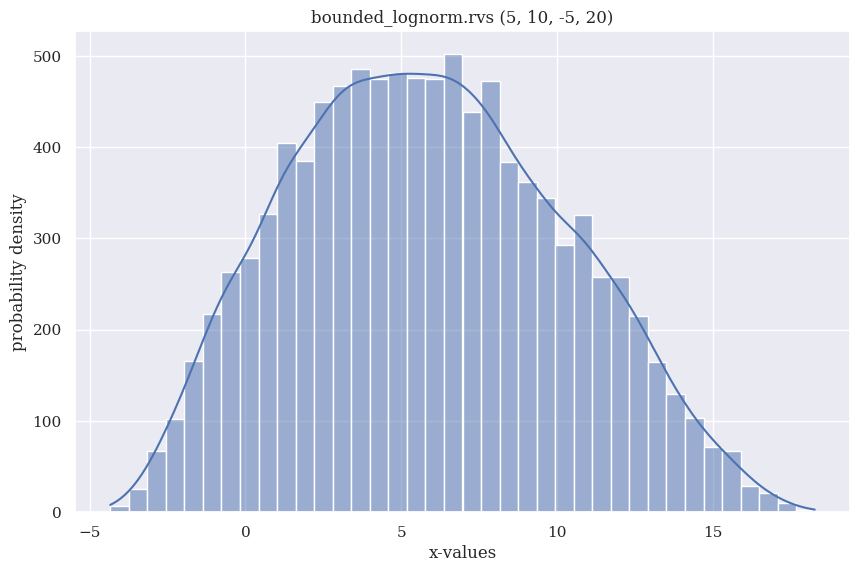

In [13]:
y = bl2.rvs(mode, sigma, lower, upper, size=10000)
sns.histplot(y, kde=True)
title = title = 'bounded_lognorm.rvs ({}, {}, {}, {})'
title = title.format(mode, sigma, lower, upper)
plt.xlabel("x-values")
plt.ylabel("probability density")
plt.title(title)
plt.show()

#### Summary Statistics

Median

In [14]:
bl2.median(mode, sigma, lower, upper)

array([5.69788841])

Mean

In [15]:
bl2.mean(mode, sigma, lower, upper)

5.867105466416374

Standard deviation

In [16]:
bl2.std(mode, sigma, lower, upper)

4.363009059596013

Note that this is *not* the same as sigma, due to the proximity of the lower and upper domain boundaries. See the section below comparing the bounded lognormal and normal distributions for an illustration.

Moments

In [17]:
mean, var, skew, kurt = bl2.stats(mode, sigma, lower, upper, moments='mvsk')
mean, var, skew, kurt

(5.867105466416374,
 19.03584805411689,
 0.16390137463483928,
 -0.6816074844745001)

In [18]:
bl2.moment(1, mode, sigma, lower, upper)

5.867105466416374

Differential Entropy

In [19]:
bl2.entropy(mode, sigma, lower, upper)

2.8591795876637227

#### Fitting Curves to Data

See for reference
* https://www.mathworks.com/help/stats/examples/fitting-a-univariate-distribution-using-cumulative-probabilities.html
* https://math.stackexchange.com/questions/2365267/pdf-vs-cdf-fitting
* http://www.mathwave.com/articles/distribution-fitting-graphs.html

Create some noisy random numbers and fit them to a bounded_lognorm.pdf using non-linear least squares.

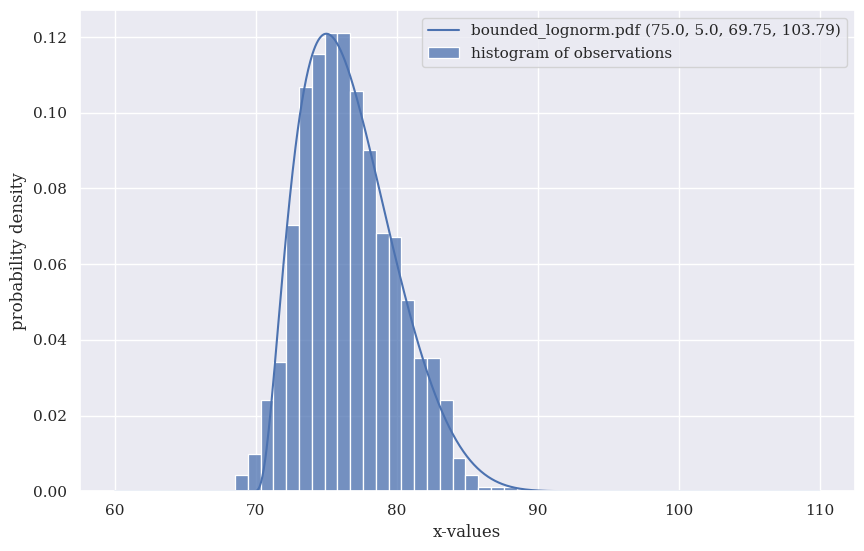

In [20]:
sample_size = 1000
data = bl2.rvs(75, 5, 70, 100, size=sample_size)
data += 1 * np.random.normal(0, 1, size=sample_size) # add some noise

# Here, fmode=75 and fsigma=5 mean fix the params mode and sigma to 75 and 5,
# respectively, and estimate the other params.
shapes, results = bl2.fit(data, MLE=False, verbose=True, fmode=75, fsigma=5)

shapes_rounded = tuple(shapes.round(2))
label = ('bounded_lognorm.pdf ' + str(shapes_rounded))

xdata = np.linspace(60, 110, sample_size)
sns.lineplot(x=xdata, y=bl2.pdf(xdata, *shapes), label=label)
sns.histplot(data, kde=False, stat='density',
             label="histogram of observations")
plt.xlabel("x-values")
plt.ylabel("probability density")
plt.legend(loc='upper right')
plt.show()

Covariance matrix of estimated parameters, in this case `lower` and `upper`

In [21]:
pcov = results[1]
pcov

array([[ 0.00013552, -0.00089866],
       [-0.00089866,  0.02242261]])

Standard deviation of estimated parameters, in this case `lower` and `upper`

In [22]:
np.sqrt(np.diag(pcov))

array([0.01164138, 0.14974183])

Fit the same random numbers to a bounded_lognorm.pdf using maximum likelihood estimation.

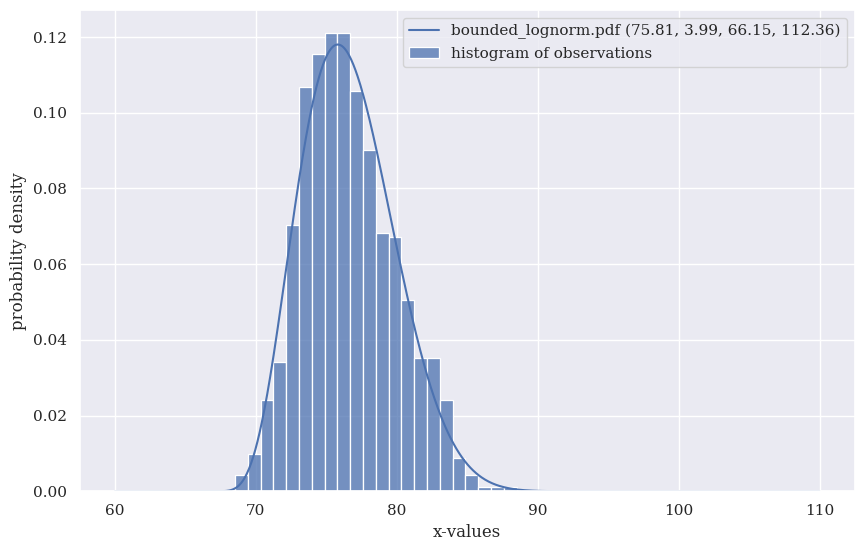

In [23]:
# Here, gmode=75 and gsigma=5 mean provide initial guesses of 75 and 5 to
# mode and sigma, respectively. All parameters here are estimated.
shapes = bl2.fit(data, MLE=True, verbose=False,
                             gmode=75, gsigma=5)

shapes_rounded = tuple(shapes.round(2))
label = ('bounded_lognorm.pdf ' + str(shapes_rounded))

xdata = np.linspace(60, 110, sample_size)
sns.lineplot(x=xdata, y=bl2.pdf(xdata, *shapes), label=label)
sns.histplot(data, kde=False, stat='density', label="histogram of observations")
plt.xlabel("x-values")
plt.ylabel("probability density")
plt.legend(loc='upper right')
plt.show()

### Inflection Points and Inflection Triangles

Similar to [Wise (1952)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1467-9574.1966.tb00496.x), here are functions to plot a pdf, its associated inflection triangle, and the relevant points. See also:
* https://www.randomservices.org/random/special/LogNormal.html
* https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1467-9574.1966.tb00496.x
* https://stackoverflow.com/questions/49635428/tangent-to-curve-interpolated-from-discrete-data
* https://www.researchgate.net/figure/Global-characteristics-of-a-lognormal-curve-used-by-the-Wise-method-tangents-at-the_fig3_220360160
* and entropy https://www.mdpi.com/1099-4300/19/2/56/htm

In [24]:
def inflection_points(mode, sigma, lower, upper):
    def inflection(mode, sigma):
        mu_N, sigma_N = lognorm_params(mode, sigma)
        return np.exp(mu_N
                      - 1.5 * sigma_N**2
                      - 0.5 * sigma_N * np.sqrt(sigma_N**2 + 4))
    I0x = inflection(mode - lower, sigma) + lower
    I1x = upper - inflection(upper - mode, sigma)
    #I0y, I1y = bounded_lognorm.pdf([I0x, I1x], mode, sigma, lower, upper)
    I0y, I1y = bl2.pdf([I0x, I1x], mode, sigma, lower, upper)
    return (I0x, I0y), (I1x, I1y)

def triangle_area(A, B, C):
    area = (A[0] * (B[1] - C[1]) +
            B[0] * (C[1] - A[1]) +
            C[0] * (A[1] - B[1])) / 2
    return np.abs(area)

def quadrilateral_area(A, B, C, D):
    return triangle_area(A, B, C) + triangle_area(C, D, A)

def length(A, B):
    return np.sqrt((A[0] - B[0])**2 + (A[1] - B[1])**2)

def slope(A, B):
    return (A[1] - B[1]) / (A[0] - B[0])

def angle(A, B, C, degrees=False):
    a = np.arctan2(np.array([A[1] -B[1]]), np.array([A[0] -B[0]]))
    b = np.arctan2(np.array([C[1] -B[1]]), np.array([C[0] -B[0]]))
    angle = np.abs(b - a)
    if degrees:
        angle = np.rad2deg(angle)
    return angle

def intersection(A, B, C, D):
    slope0 = slope(A, B)
    slope1 = slope(C, D)
    y_intercept0 = A[1] - slope0 * A[0]
    y_intercept1 = C[1] - slope1 * C[0]
    x = -(y_intercept1 - y_intercept0) / (slope1 - slope0)
    y = slope0 * x + y_intercept0
    return x, y

def tangent_at_inflection(I, x, y):
    inflection = I[0]
    i = np.argmin(np.abs(x - inflection))
    x1 = x[i:i+2]
    y1 = y[i:i+2]
    dydx = np.diff(y1) / np.diff(x1)
    f = lambda x: dydx * x + (y1[0] - dydx * x1[0])
    slope_ = slope((x[1], f(x[1])), (x[0], f(x[0])))[0]
    y_intercept = (f(x[1]) - slope_ * x[1])[0]
    x_intercept = -y_intercept/slope_
    return slope, x_intercept, y_intercept

def plot_point(text, xy, xyoffset, ha='left',
               arrow=True, show_coords=True, round=3):
    plt.plot(xy[0], xy[1], marker='o', markersize=3, color="red")
    arrowprops = dict(arrowstyle='->', color='k') if arrow else None
    if show_coords:
        xyr = tuple(np.array(xy).flatten().round(round))
        text = text + ":" + str(xyr)
    plt.annotate(text, xy=xy, xycoords='data',
                    xytext=xyoffset, textcoords='offset points',
                    va='center', ha=ha, arrowprops=arrowprops)

def plot_segment(A, B):
    plt.plot((A[0], B[0]), (A[1], B[1]))

def plot_triangle(mode, sigma, lower, upper,
                  plot=True, xmin=None, xmax=None,
                  show_coords=True, round=3,
                  return_coords=False):

    def plot_point_(text, xy, xyoffset, ha='left', arrow=True):
        if xmin <= xy[0] <= xmax:
            plot_point(text, xy, xyoffset, ha, arrow, show_coords, round)

    if xmin is None: xmin = lower
    if xmax is None: xmax = upper
    x = np.linspace(xmin, xmax, 1000)
    #y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
    y = bl2.pdf(x, mode, sigma, lower, upper)

    M = mode, 0
    #N = mode, bounded_lognorm.pdf(mode, mode, sigma, lower, upper)[0]
    N = mode, bl2.pdf(mode, mode, sigma, lower, upper)
    I, J = inflection_points(mode, sigma, lower, upper)
    A = tangent_at_inflection(I, x, y)[1], 0  # x-intercept of left leg
    B = tangent_at_inflection(J, x, y)[1], 0  # x-intercept of right leg
    C = intersection(A, I, B, J)  # triangle apex
    L, U = (lower, 0), (upper, 0)  # upper and lower bounds at x=0

    if plot:
        #warning_category = np.VisibleDeprecationWarning
        #np.warnings.filterwarnings('ignore', category=warning_category)
        sns.lineplot(x=x, y=y)

        plot_segment(A, C)  # left leg
        plot_segment(B, C)  # right leg
        plot_segment(A, B)  # base
        plot_segment(I, J)  # base of smaller triangle

        plot_point_("A", A, (-40, 20), ha='right', arrow=True)
        plot_point_("B", B, (40, 20), ha='left', arrow=True)
        plot_point_("C", C, (10, 0), arrow=False)
        plot_point_("I", I, (-10, 0), ha='right', arrow=False)
        plot_point_("J", J, (10, 0), arrow=False)
        plot_point_("M", M, (0, 15), ha='center', arrow=False)
        plot_point_("N", N, (40, 0), arrow=True)
        plot_point_("L", L, (-10, 0), ha='right', arrow=False)
        plot_point_("U", U, (10, 0), ha='left', arrow=False)

        title = ('bounded_lognorm.pdf ({}, {}, {}, {}) ' +
                 'and its associated inflection triangle')
        title = title.format(mode, sigma, lower, upper)
        plt.title(title)
        plt.ylabel("probability density")
        plt.xlabel("x-values")
        plt.show()

    if return_coords:
        return A, B, C, I, J, M, N, L, U

def plot_angle_vs_dispersion(mode, lower, upper, sigma_mult=100, n=1000,
                             plot_sigma=False, plot_degrees=False,
                             plot_max=True):
    d = upper - lower
    sigma_range = np.array([0.1, sigma_mult]) * d
    disps, angs = [], []
    for sigma in np.linspace(sigma_range[0], sigma_range[1], n):
        params = mode, sigma, lower, upper
        specs = plot_triangle(*params, return_coords=True, plot=False)
        A, B, C, I, J, M, N, L, U = specs
        #disp = sigma if plot_sigma else bounded_lognorm.std(*params)[0]
        disp = sigma if plot_sigma else bl2.std(*params)[0]
        disps.append(disp)
        ang = angle(A, C, B)[0]
        angs.append(ang)
    disps, angs = np.array(disps), np.array(angs)
    angs = np.rad2deg(angs) if plot_degrees else angs
    sns.lineplot(x=disps, y=angs)
    max_ang = max(angs)
    disp_at_max_ang = disps[angs.argmax()]
    if plot_max:
        xoffset = 50 if plot_sigma else 0
        plot_point('max', [disp_at_max_ang, max_ang],
                   (xoffset, -40), ha='center')
    title = 'bounded_lognorm({}, sigma, {}, {}) over a range of sigmas'
    title = title.format(mode, lower, upper)
    plt.title(title)
    plt.ylabel("angle (degrees)" if plot_degrees else "angle (radians)")
    plt.xlabel("sigma" if plot_sigma else "standard deviation")
    plt.show()

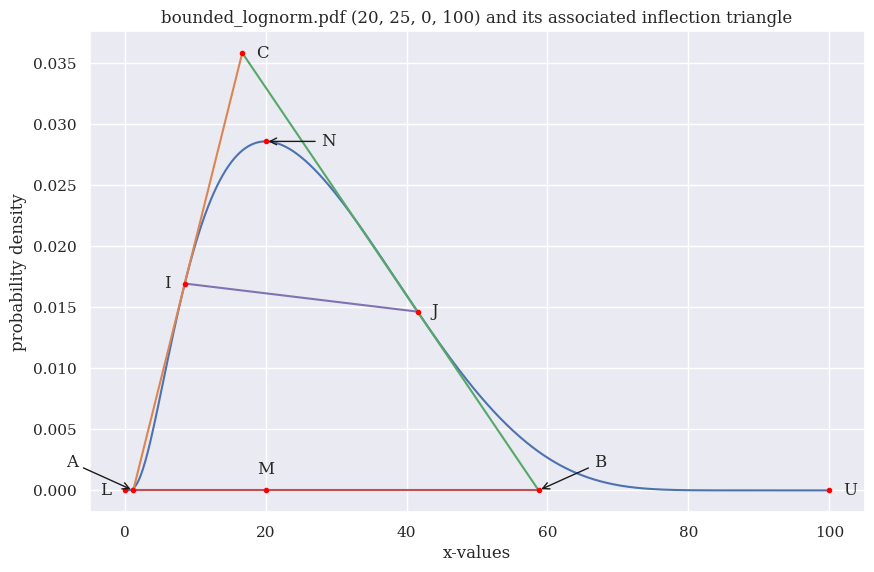

In [25]:
mode, sigma, lower, upper = 20, 25, 0, 100
specs = plot_triangle(mode, sigma, lower, upper,
                      xmin=None, xmax=None,
                      return_coords=True, show_coords=False)
A, B, C, I, J, M, N, L, U = specs

In [26]:
length(A, B), length(A, C)*2, length(C, B), length(I, C)

(57.543760310465764, 30.951217514343263, 42.06820835753568, 8.159464150329738)

In [27]:
length(I, C), length(I, A)

(8.159464150329738, 7.316144606841893)

### Comparing to Other Distributions

#### The Normal Distribution

Let's first define a function that plots a normal pdf and a symmetrical bounded lognormal pdf for comparison. Include the 95% confidence interval for each. A symmetrical bounded lognormal distribution is one in which the mode is the midpoint between the lower and upper boundaries. Take as a paramater spread or distance from the mode to the domain boundaries.

In [28]:
def compare_to_standard_N(spread):
    mode, sigma = 0, 1
    lower = mode - spread
    upper = mode + spread

    x = np.linspace(-4, 4, 1000)
    y = bl2.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x=x, y=y, label='bounded_lognorm.pdf')
    interval = bl2.interval(0.95, mode, sigma, lower, upper)
    plt.axvline(interval[0], ymin=0, linestyle='dashed',
                label='bounded_lognorm 95% conf. interval')
    plt.axvline(interval[1], ymin=0, linestyle='dashed')

    y = norm.pdf(x, loc=mode, scale=sigma)
    sns.lineplot(x=x, y=y, label='standard normal pdf')
    interval2 = norm.interval(0.95, loc=mode, scale=sigma)
    plt.axvline(interval2[0], ymin=0, linestyle='dashed', c='red', alpha=0.5,
                label='standard normal 95% conf interval')
    plt.axvline(interval2[1], ymin=0, linestyle='dashed', c='red', alpha=0.5)

    title = ('standard normal vs bounded lognormal with bounds at '
             + r'$\pm$' + str(spread))
    plt.title(title)
    plt.xlabel("x-values")
    plt.ylabel("probability density")
    plt.legend()
    plt.show()

As the upper and lower bounds move away from the mode, the bounded lognormal pdf appears to better approximate the normal pdf.

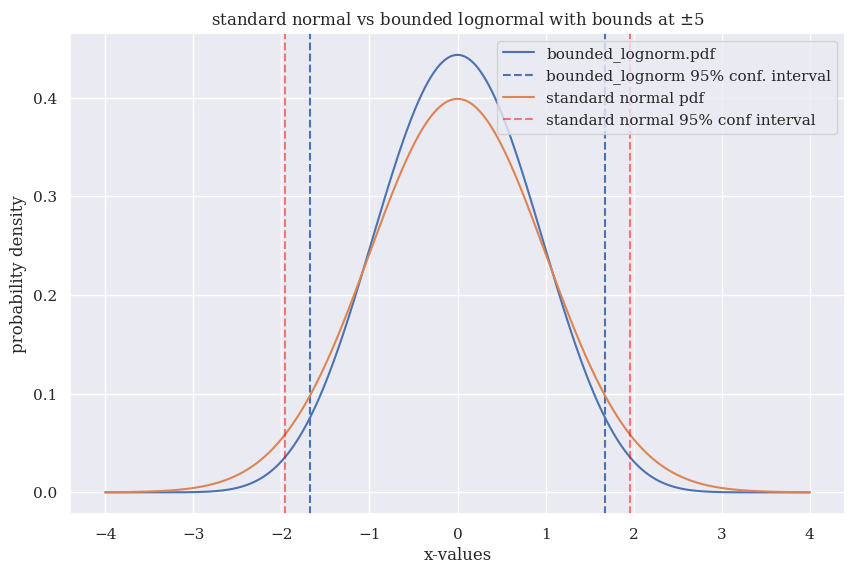

In [29]:
compare_to_standard_N(5)

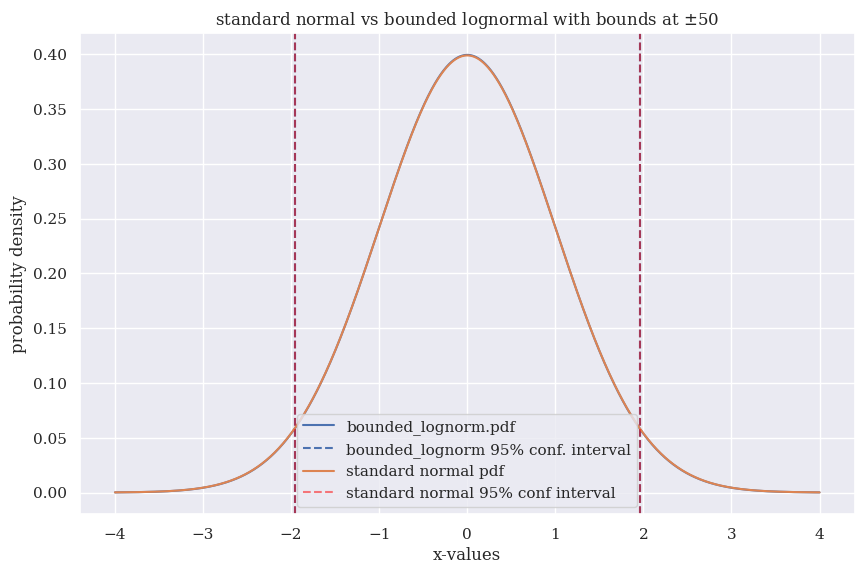

In [30]:
compare_to_standard_N(50)

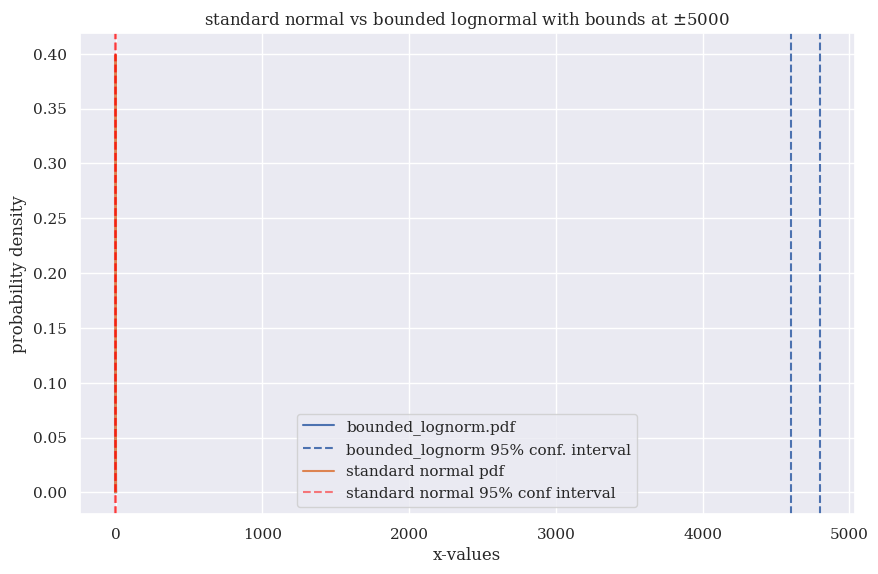

In [31]:
compare_to_standard_N(5000)
# not sure what's going on here!

In [32]:
bl2.interval(0.95, 0, 1, -5000, 5000)

(array([4602.46984992]), array([4796.97165641]))

#### The Lognormal Distribution

In [33]:
def compare_to_LN(spread, log_xscale=False):
    mode, sigma = 1, 1
    lower = 0
    upper = spread
    x = np.linspace(0, 5, 1000)

    y = bl2.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x=x, y=y, label='bounded_lognorm.pdf')
    #interval = bounded_lognorm2.interval(0.95, mode, sigma, lower, upper)
    interval = bl2.interval(0.95, mode, sigma, lower, upper)
    plt.axvline(interval[0], ymin=0, linestyle='dashed',
                label='bounded_lognorm 95% conf. interval')
    plt.axvline(interval[1], ymin=0, linestyle='dashed')

    mu_N, sigma_N = lognorm_params(mode, sigma)
    y = lognorm.pdf(x, loc=0, scale=np.exp(mu_N), s=sigma_N)
    sns.lineplot(x=x, y=y, label='lognorm.pdf')
    interval2 = lognorm.interval(0.95, loc=0, scale=np.exp(mu_N), s=sigma_N)
    plt.axvline(interval2[0], ymin=0, linestyle='dashed', c='red', alpha=0.5,
                label='lonorm 95% conf interval')
    plt.axvline(interval2[1], ymin=0, linestyle='dashed', c='red', alpha=0.5)

    if log_xscale:
        plt.xscale('log')

    title = ('bounded_lognormal.pdf ({}, {}, {}, {}) ' +
            r'vs lognorm.pdf ($\mu_N, \sigma_N$)')
    title = title.format(mode, sigma, lower, upper)
    plt.xlabel("x-values")
    plt.ylabel("probability density")
    plt.title(title)
    plt.legend()
    plt.show()

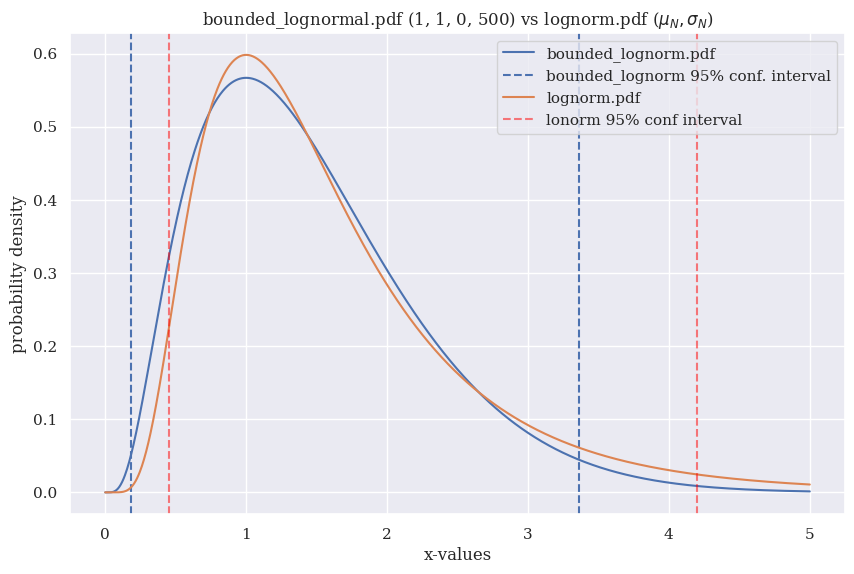

In [34]:
compare_to_LN(500)